# Analyzing Authorship of Right-Wing Media Articles

**Motivation**

Analyzing the individual authors right-wing media helps us understand the structure of the organization and to identify key
players.

**Research Problem**

• How does Article Topic, Length and Publication time differ between Authors?

• Do specific Authors specialize on a single topic?

• Does article sentiment differ between articles containing keywords relating to immigrants from articles not containing the keywords?

• How does the frequency of published articles vary over a week?

**Dataset**

Scraped data with the origin of the following website: “https://www.nius.de/”
A relational database is used to tackle this problem because of its flexibility in storing an retrieving the Data. Our data is
saved in a JSON format with a lot of redundant and unimportant information. Converting this in different database tables
not only improves performance when retrieving just partial data but also saves memory.

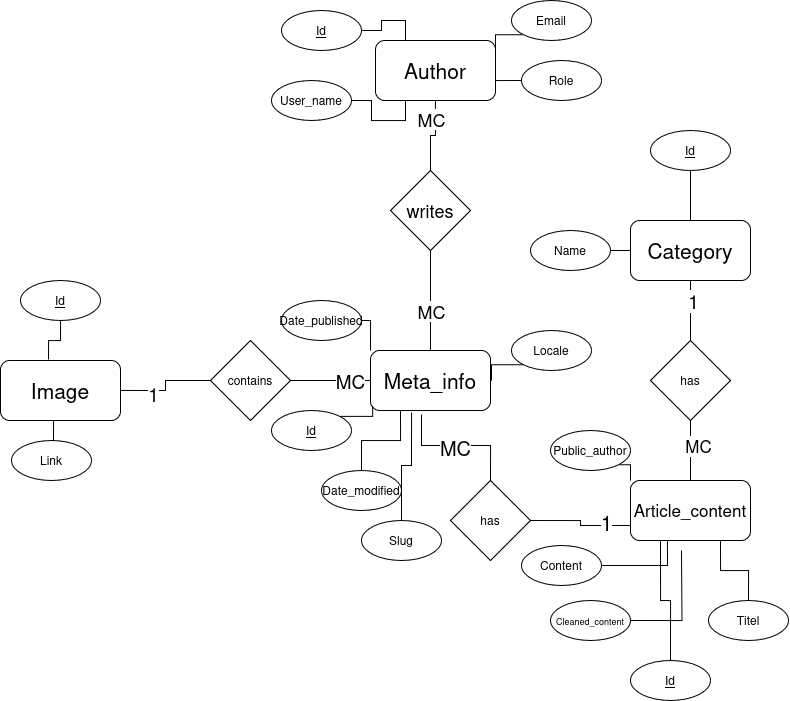

In [2]:
import pandas as pd
import pymysql
import re
import matplotlib.pyplot as plt
import matplotlib
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import numpy as np
from datetime import datetime
import seaborn as sns

In [3]:
def get_df(query: str = None, table_name: str = None) -> pd.DataFrame:
    """
    function to get data from the database.
    
    :strong:`Parameters:`
        query (str): Enter SQL query to retrive data, esle use table_name for full table data.
        table_name (str): If you want to retrieve the whole table data enter the table name.
    :strong:`Returns:`
        pd.DataFrame
    """
    #connect
    mydb = pymysql.connect(
        host="XXX",
        user="XXX",
        password="XXX",
        database="XXX"
    )
    #get data
    with mydb.cursor() as mycursor:
        if query:
            sql = f"{query}"
        else:
            sql = f"SELECT * FROM {table_name}"
        mycursor.execute(sql)
        data = mycursor.fetchall()
        column_names = [desc[0] for desc in mycursor.description]
    #close connection
    mydb.close()
    return pd.DataFrame(data, columns=column_names)

In [3]:
# #function used to clean article_content["content"]
# def clean_text(text: str) -> str:
#     """
#     Clean the input text by removing HTML tags, entities, and other artifacts.

#     Args:
#         text (str): The raw input text.

#     Returns:
#         str: The cleaned text.
#     """
#     # Remove HTML tags
#     text = re.sub(r"<.*?>", " ", text)
    
#     # Remove HTML entities (e.g., &nbsp;, &amp;)
#     text = re.sub(r"&.*?;", " ", text)

#     # Remove JSON like structure
#     text = re.sub(r"'\[\{'type': 'HTML', 'data': '", " ", text)
#     text = re.sub(r"'}.*?HTML', 'data': ", "", text)
    
#     # Replace newline and other letters/characters with whitespaces 
#     text = text.replace("\\n", " ").replace("\n", " ").replace("'}]'", " ").replace(' “', '“').replace('“ ,', '“,').replace(r"\xad-", "")

#     # Normalize whitespace to a single space
#     text = re.sub(r" +", " ", text).strip()
#     text = re.sub(r" type.*? data", " ", text).strip()

#     return text

# article_content_clean = get_df(table_name="article_content")
# article_content_clean["content"] = article_content_clean["content"].apply(clean_text)
# #article_content_clean.to_csv("cleaned_data_article_content")
# article_content_clean.head()

In [4]:
query = "SELECT ac.id, ac.public_author, cat.name \
        FROM article_content ac \
        INNER JOIN category cat \
            ON ac.kategorie_id = cat.id \
        WHERE ac.public_author IS NOT NULL AND cat.name IS NOT NULL \
"
article_content_category_df = get_df(query=query)

In [5]:
#Drop NaNs:
article_content_category_df = article_content_category_df[
    (article_content_category_df["public_author"] != "NaN") & 
    (article_content_category_df["name"] != "NaN")
]
article_content_category_df.rename(columns={"name": "category"}, inplace=True)

#rename sport to Sport, news to Nachrichten:
article_content_category_df.loc[article_content_category_df["category"] == "sport", "category"] = "Sport"
article_content_category_df.loc[article_content_category_df["category"] == "News", "category"] = "Nachrichten"

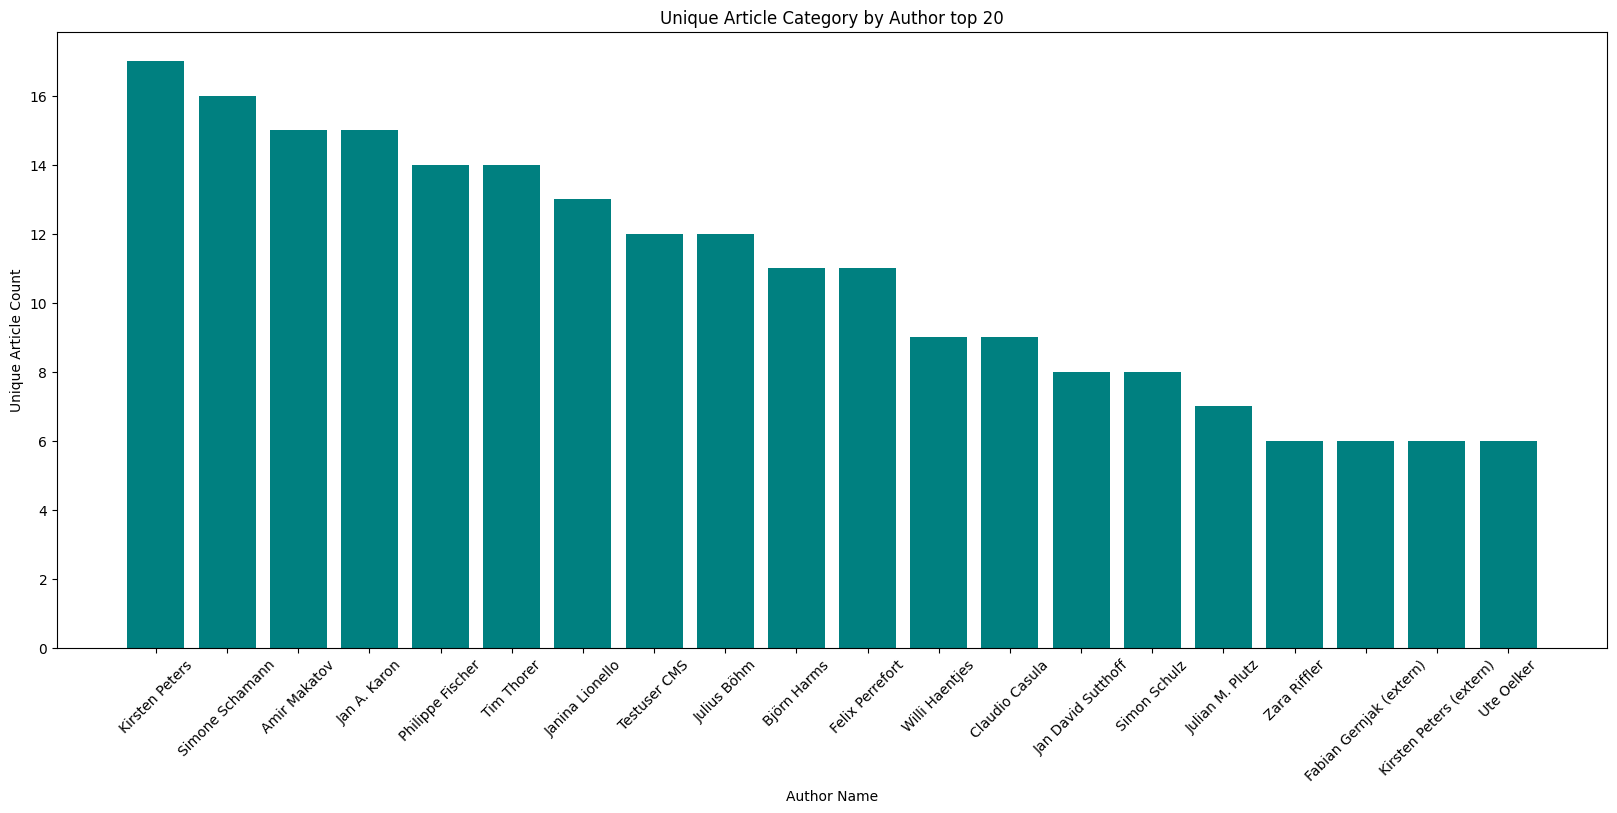

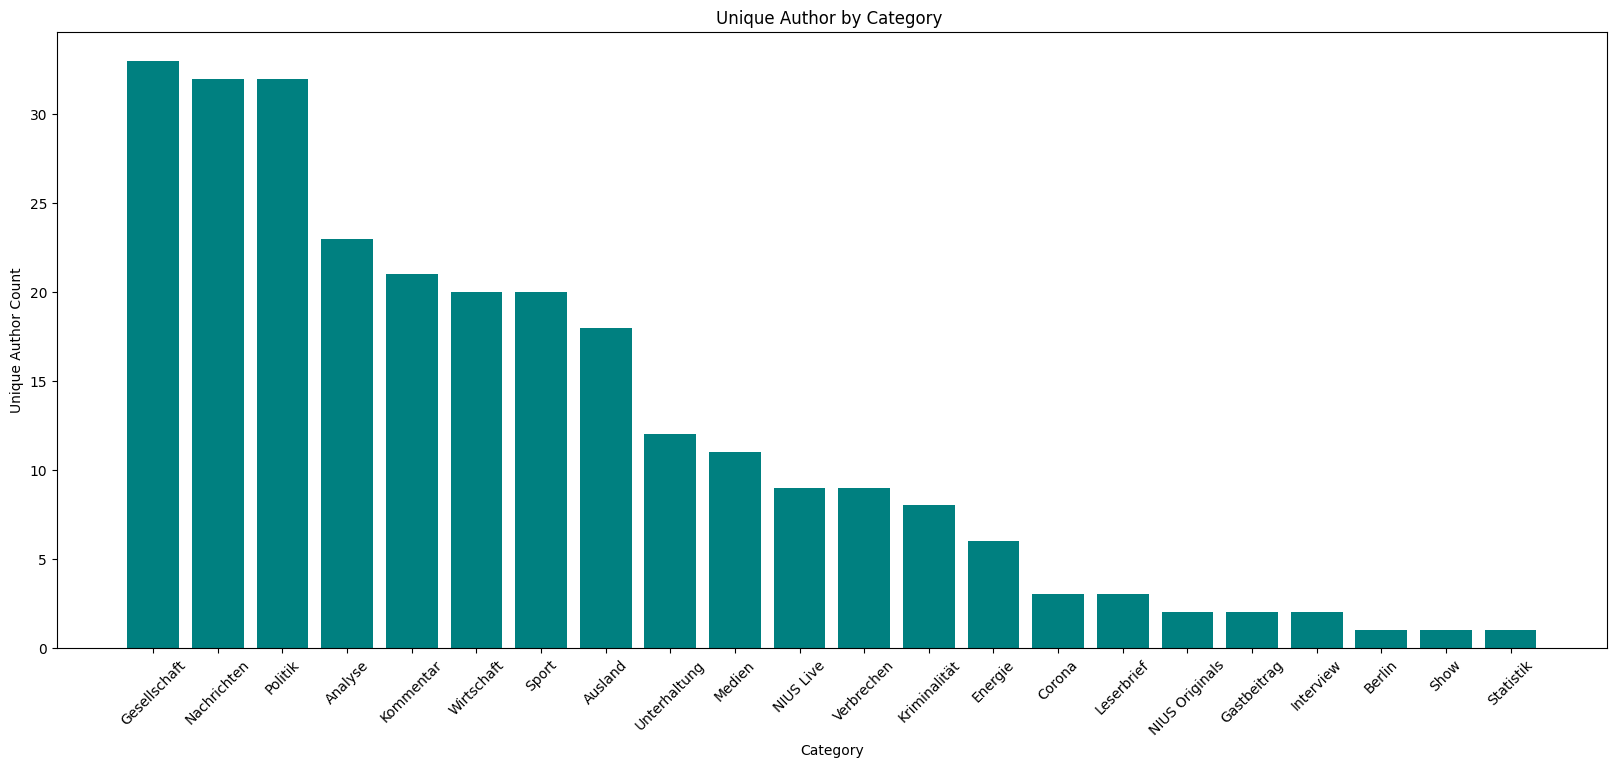

In [26]:
#unique article category by author:
category_by_author = article_content_category_df.groupby("public_author")["category"].nunique().sort_values(ascending=False)

#unique author by article category:
author_by_category = article_content_category_df.groupby("category")["public_author"].nunique().sort_values(ascending=False)

def plot_category(data: pd.DataFrame,
                  title: str, 
                  x_label: str, 
                  y_label: str, 
                  head_or_tail: str = "head",
                  n: int = 5,
                  show_n: bool = False,
                  show_se: bool = False) -> None:
    
    se = data.head(n).sem() if show_se else None
    data = data.head(n) if head_or_tail == "head" else data.tail(n)
    show_n = f"top {n}" if show_n and head_or_tail == "head" else f"bottom {n}" if show_n and head_or_tail == "tail" else ""
    
    plt.figure(figsize=(20, 8))
    plt.bar(
        data.index,
        data.values,
        color="teal",
        yerr=se,
        capsize=5
)
    plt.title(f"{title} {show_n}")    
    plt.xlabel(x_label)
    plt.ylabel(f"{y_label}")    
    plt.xticks(rotation=45)
    
plot_category(category_by_author, "Unique Article Category by Author", "Author Name", "Unique Article Count", n=20, show_n=True,head_or_tail="head")
plot_category(author_by_category, "Unique Author by Category", "Category", "Unique Author Count", n=100)

In [7]:
query= "SELECT title, cleaned_content, public_author FROM article_content"
article_content_df = get_df(query)

article_content_df["content_length_characters"] = article_content_df["cleaned_content"].apply(len)
article_content_df["content_length_words"] = article_content_df["cleaned_content"].apply(lambda x: len(x.split()))
article_length = article_content_df.groupby("public_author")[["content_length_characters", "content_length_words"]].mean().round(2)

article_length_sorted_by_words = article_length.sort_values(by="content_length_words", ascending=False)
article_length_sorted_by_characters = article_length.sort_values(by="content_length_characters", ascending=False)

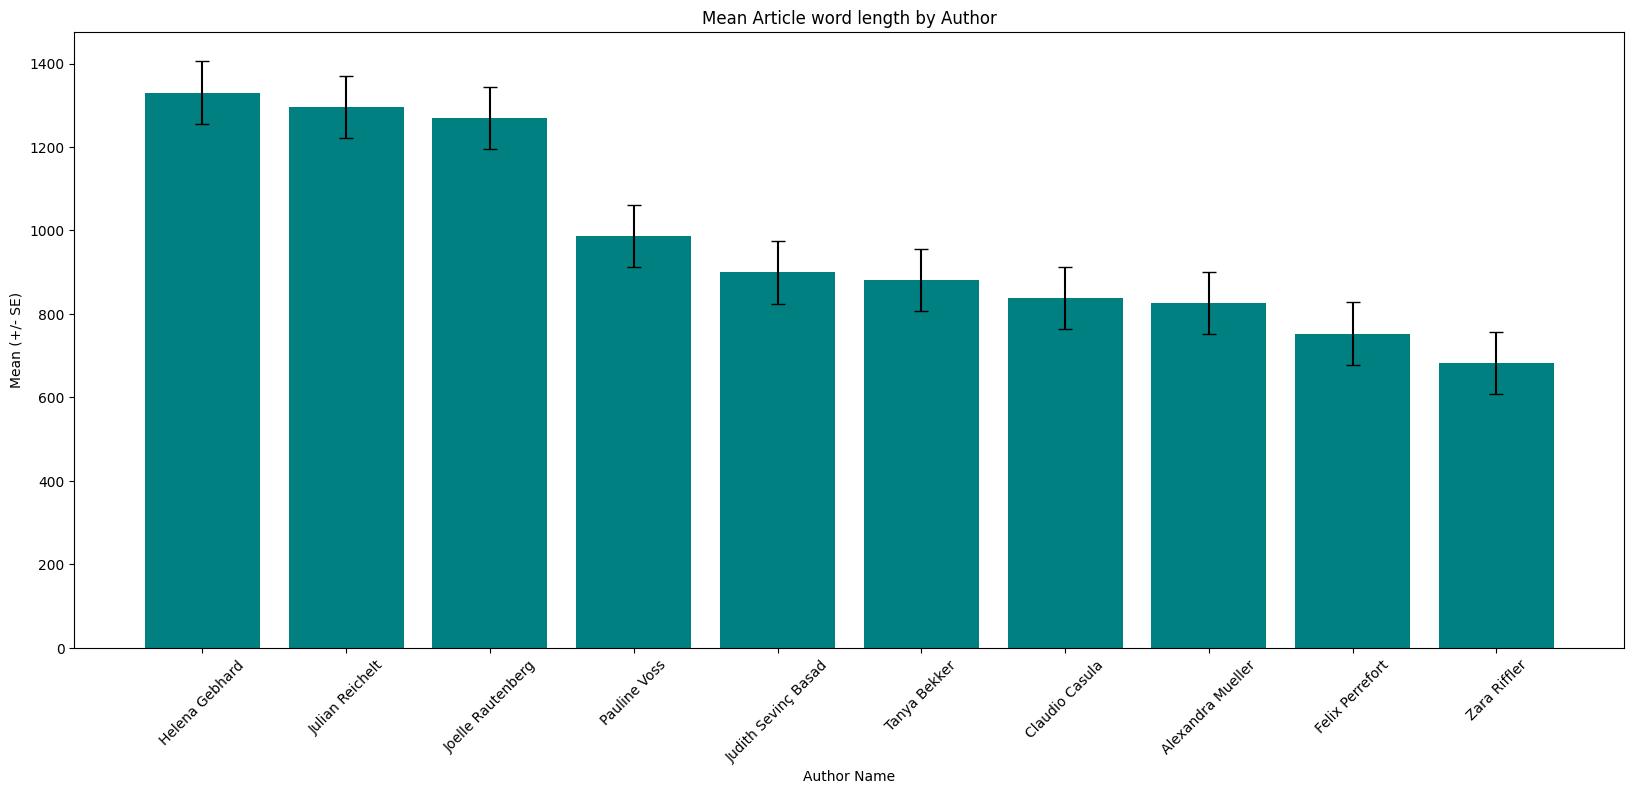

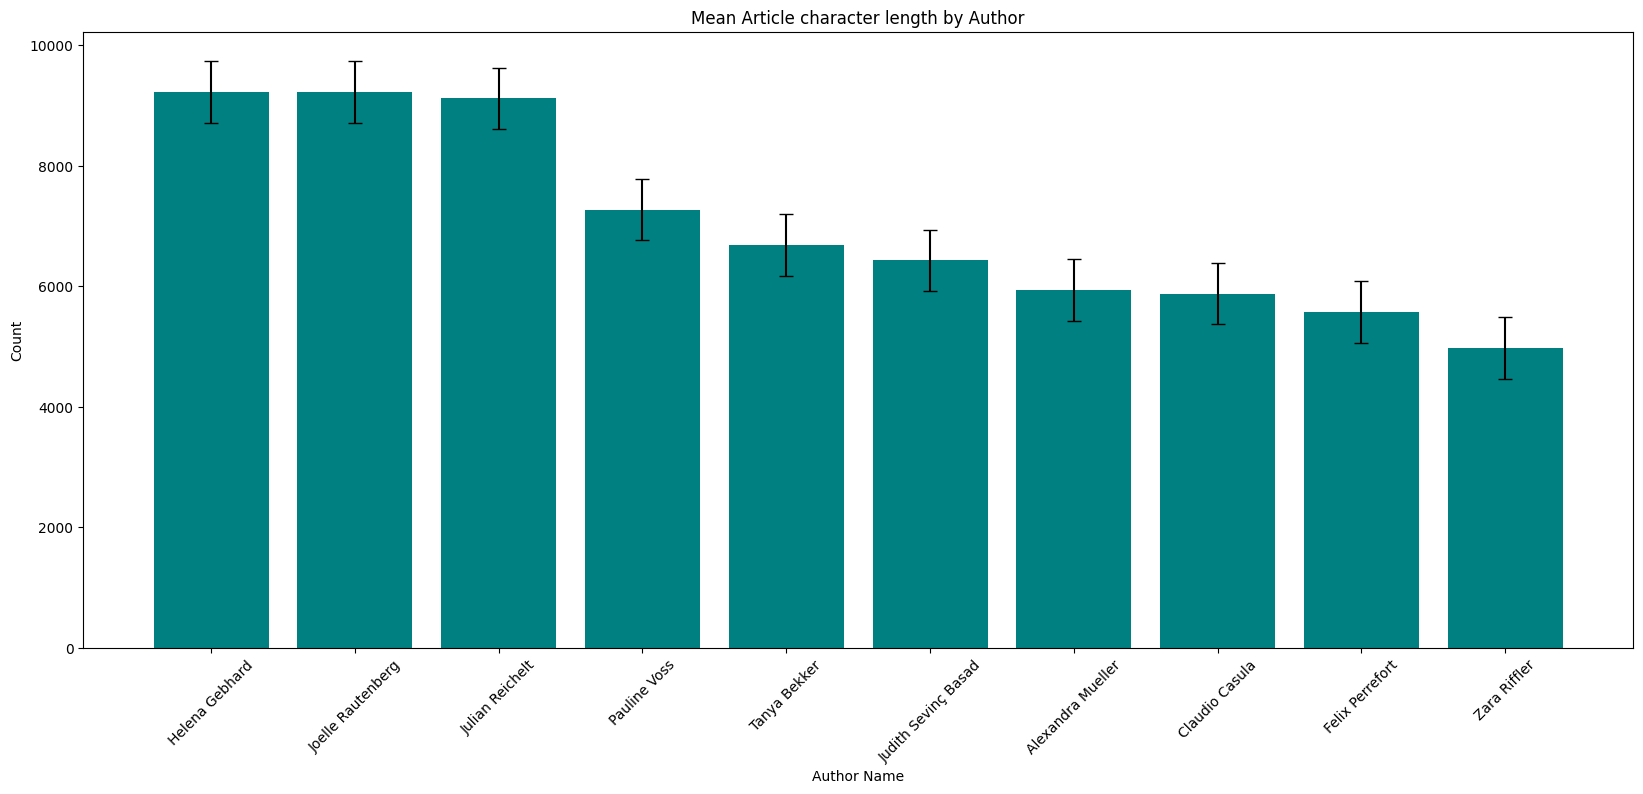

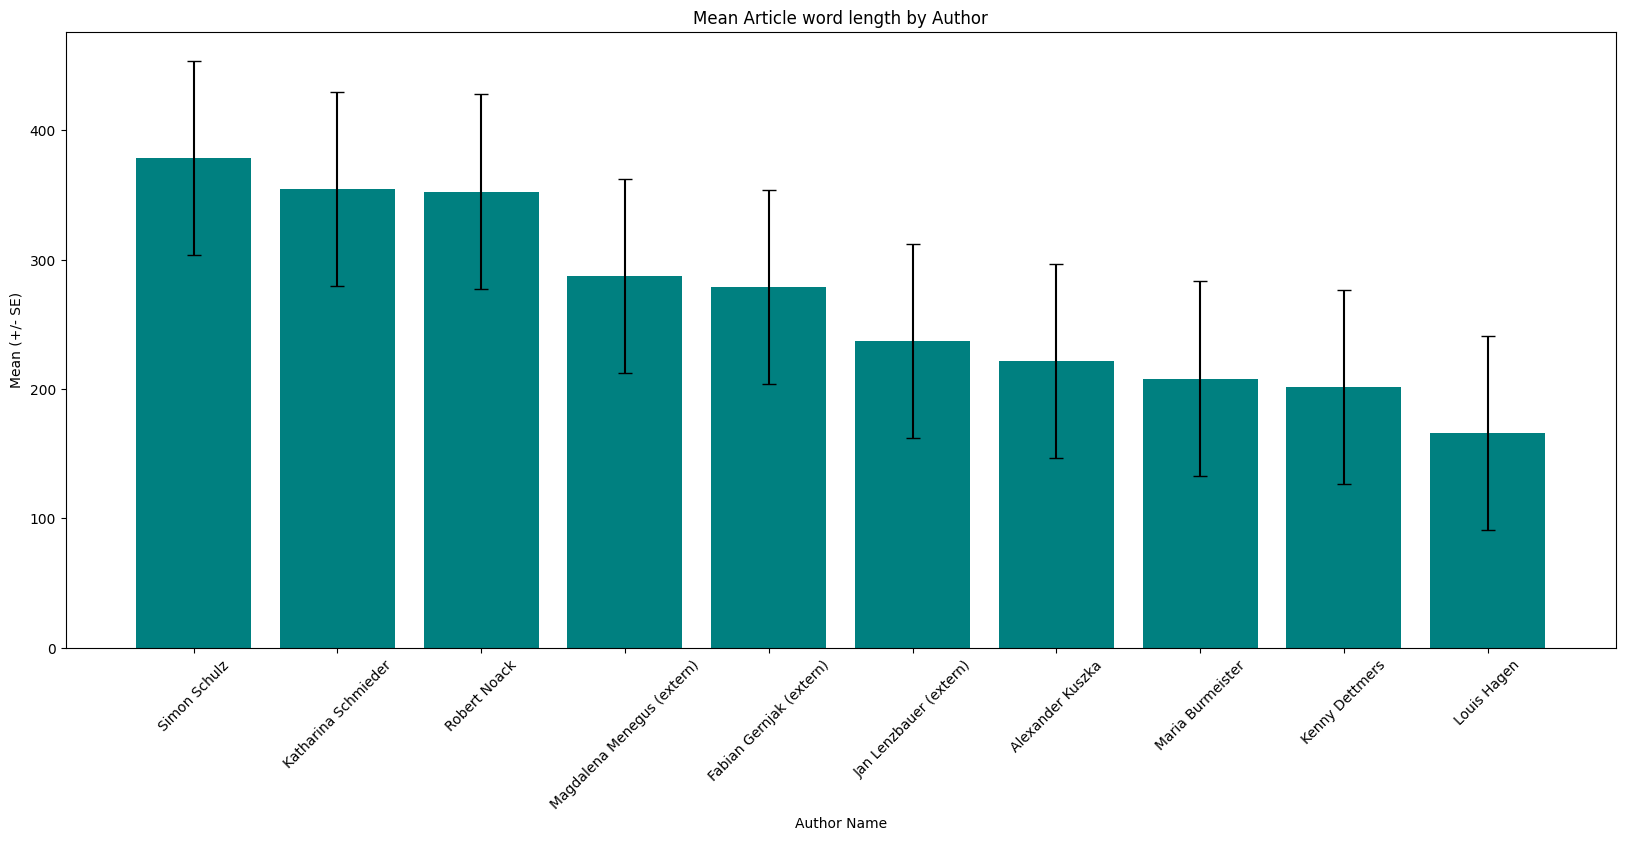

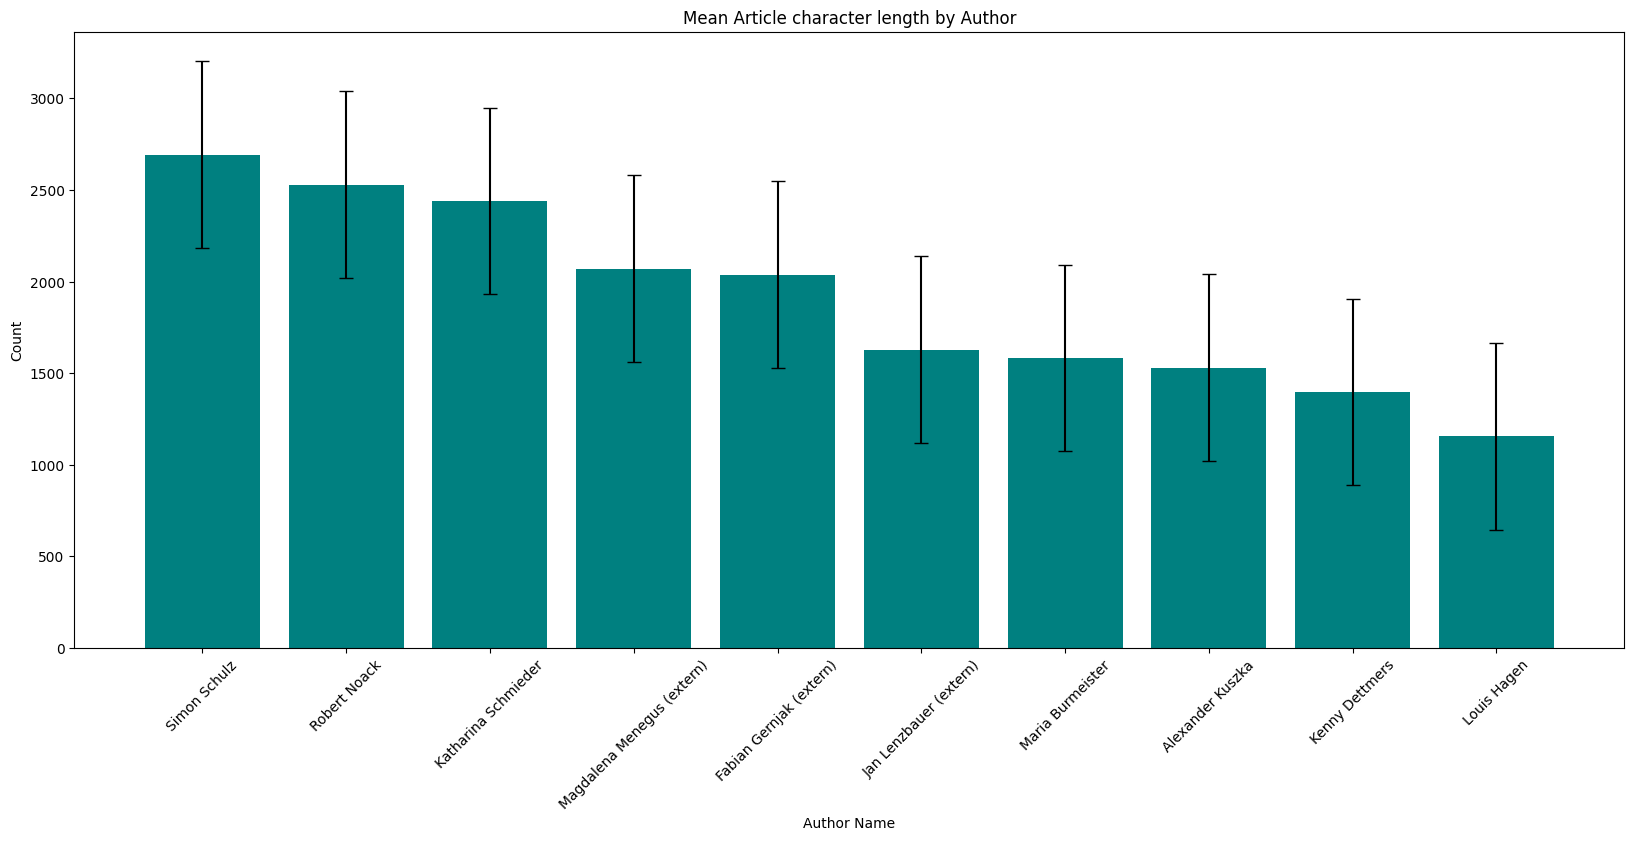

In [19]:
def plot_article_length(data: pd.DataFrame, column: str, title: str, y_label:str, n: int = 5, head_or_tail: str = "head") -> None:
    se = data.head(n)[column].sem()
    data = data.head(n) if head_or_tail == "head" else data.tail(n)

    plt.figure(figsize=(20, 8))
    plt.bar(
        data.index,
        data[column].values,
        color="teal",
        yerr=se,
        capsize=5
)
    plt.title(f"{title}")    
    plt.xlabel("Author Name")
    plt.ylabel(y_label)    
    plt.xticks(rotation=45)
    
plot_article_length(article_length_sorted_by_words, "content_length_words", "Mean Article word length by Author", y_label="Mean (+/- SE)",n=10)
plot_article_length(article_length_sorted_by_characters, "content_length_characters", "Mean Article character length by Author", y_label="Count", n=10)

plot_article_length(article_length_sorted_by_words, "content_length_words", "Mean Article word length by Author", n=10, head_or_tail="tail", y_label="Mean (+/- SE)")
plot_article_length(article_length_sorted_by_characters, "content_length_characters", "Mean Article character length by Author", n=10, head_or_tail="tail", y_label="Count")

In [21]:
def keyword_counter(data: pd.DataFrame, keyword: list[str], column: str = "cleaned_content") -> pd.DataFrame:
    """
    Counts occurrences of keywords in a specific column of a DataFrame, case-insensitively
    and combines them into a single column.
    
    Args:
        keyword (list[str]): List of keywords to count.
        data (pd.DataFrame): Original DataFrame.
        column (str): The column to search for keywords. Defaults to 'cleaned_content'.

    Returns:
        pd.DataFrame: A new DataFrame with a combined keyword count column.
    """
    data_copy = data.copy()
    combined_count_column = "combined_keyword_count"
    data_copy[combined_count_column] = 0  
    
    for word in keyword:
        count_col = data_copy[column].str.count(rf'\b{word}\b', flags=re.IGNORECASE)
        data_copy[combined_count_column] += count_col  
    
    return data_copy

In [22]:
query= "SELECT title, cleaned_content, public_author FROM article_content"
article_content_df = get_df(query)
article_content_df = article_content_df.head(1_000)
sentiment_pipeline = pipeline("sentiment-analysis", model="oliverguhr/german-sentiment-bert")

# Truncate the input text to the maximum length that the BERT model can handle
max_length = 512
truncated_content = article_content_df["cleaned_content"].apply(lambda x: x[:max_length])

article_content_classified = sentiment_pipeline(truncated_content.to_list())
article_content_classified_df = pd.DataFrame(article_content_classified)
article_content_classified_df["Bert_class"] = [result["label"] for result in article_content_classified]


In [23]:
merged = pd.concat([article_content_classified_df, article_content_df], axis=1)

keyword = ["Ausländer", "Immigranten", "Immigration", "Migrationshintergrund", "Migrantinnen", "Migranten", "Zuwanderer", "Einwanderer"]

content_analyzed = keyword_counter(merged, keyword)

In [24]:
content_analyzed_keyword = content_analyzed[content_analyzed["combined_keyword_count"] != 0]
content_analyzed_no_keyword = content_analyzed[content_analyzed["combined_keyword_count"] == 0]

grouped_keyword = content_analyzed_keyword.groupby("Bert_class").count()
grouped_no_keyword = content_analyzed_no_keyword.groupby("Bert_class").count()

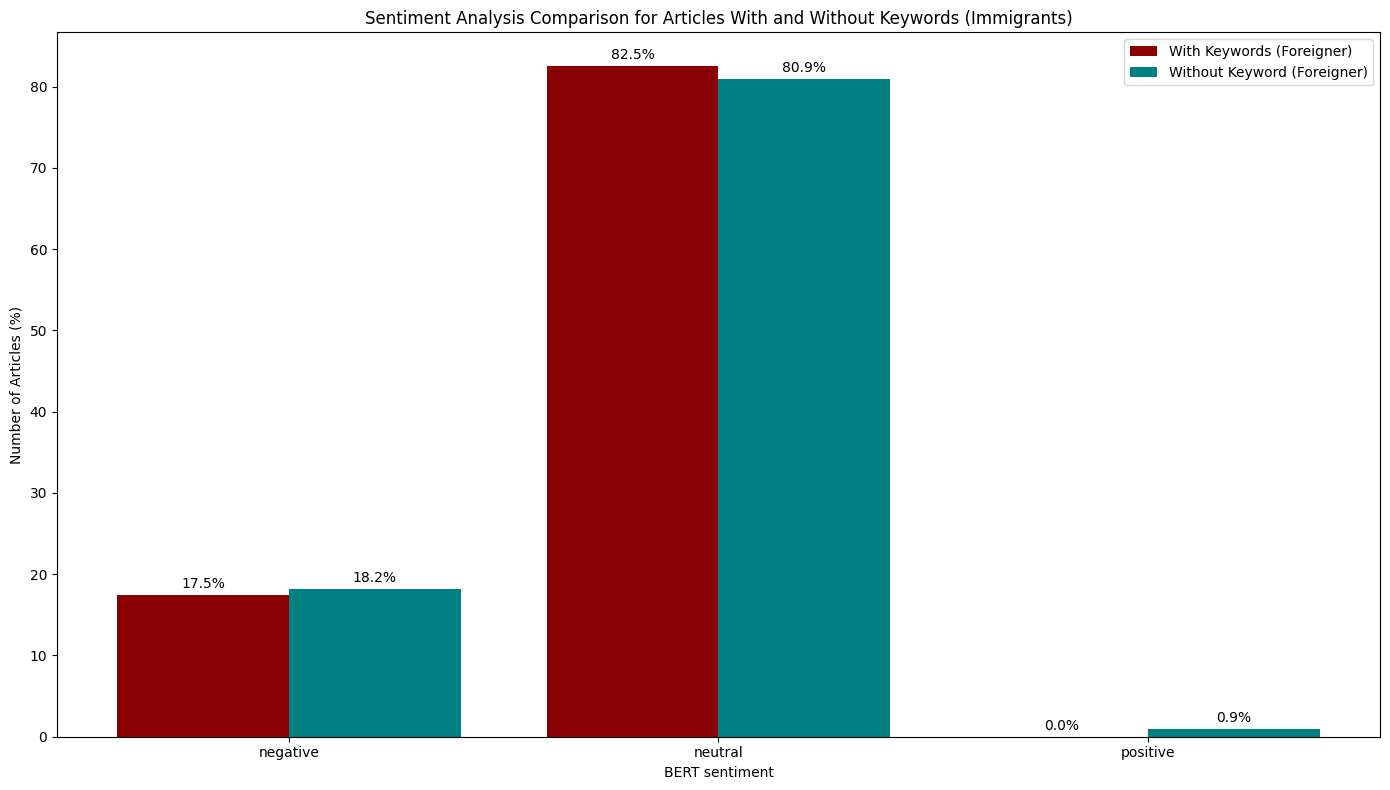

In [25]:
def plot_sentiment_analysis(data1: pd.DataFrame, data2: pd.DataFrame, 
                            title: str,
                            column: str = "combined_keyword_count",
                            keyword_label = "Foreigner") -> None:
        
    # Get all unique sentiment categories
    all_categories = sorted(set(data1.index) | set(data2.index))
    
    # Reindex both DataFrames to include all categories, filling missing values with 0
    data1_aligned = data1.reindex(all_categories, fill_value=0)
    data2_aligned = data2.reindex(all_categories, fill_value=0)
    
    total1 = data1_aligned[column].sum()
    percentage_value1 = (data1_aligned[column].values / total1) * 100
    
    total2 = data2_aligned[column].sum()
    percentage_value2 = (data2_aligned[column].values / total2) * 100
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(all_categories))
    width = 0.4
    
    bars1 = ax.bar(
        x - width/2,
        percentage_value1,
        width, 
        color="darkred",
        label=f"With Keywords ({keyword_label})")
    
    bars2 = ax.bar(
        x + width/2, 
        percentage_value2, 
        width, color="teal", 
        label=f"Without Keyword ({keyword_label})")
    
    ax.set_title(title)
    ax.set_xlabel("BERT sentiment")
    ax.set_ylabel("Number of Articles (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(all_categories)
    ax.legend()
    
    ax.bar_label(bars1, fmt='%.1f%%', padding=3, label_type='edge')
    ax.bar_label(bars2, fmt='%.1f%%', padding=3, label_type='edge')
    
    plt.tight_layout()

plot_sentiment_analysis(
    grouped_keyword, 
    grouped_no_keyword,
    f"Sentiment Analysis Comparison for Articles With and Without Keywords (Immigrants)"
)

In [9]:
query = "SELECT mi.id, mi.date_published, ac.public_author \
        FROM meta_info mi \
        INNER JOIN article_content ac \
            ON mi.id = ac.id"
            
publication_time = get_df(query)
publication_time = publication_time.dropna()
publication_time["weekday_name"] = publication_time["date_published"].dt.day_name()
publication_time["weekday_num"] = publication_time["date_published"].dt.weekday
publication_time["hour"] = publication_time["date_published"].dt.hour
publication_time["week"] = publication_time["date_published"].dt.isocalendar().week

Earliest publication: 4.0 h
Latest publication: 17.0 h


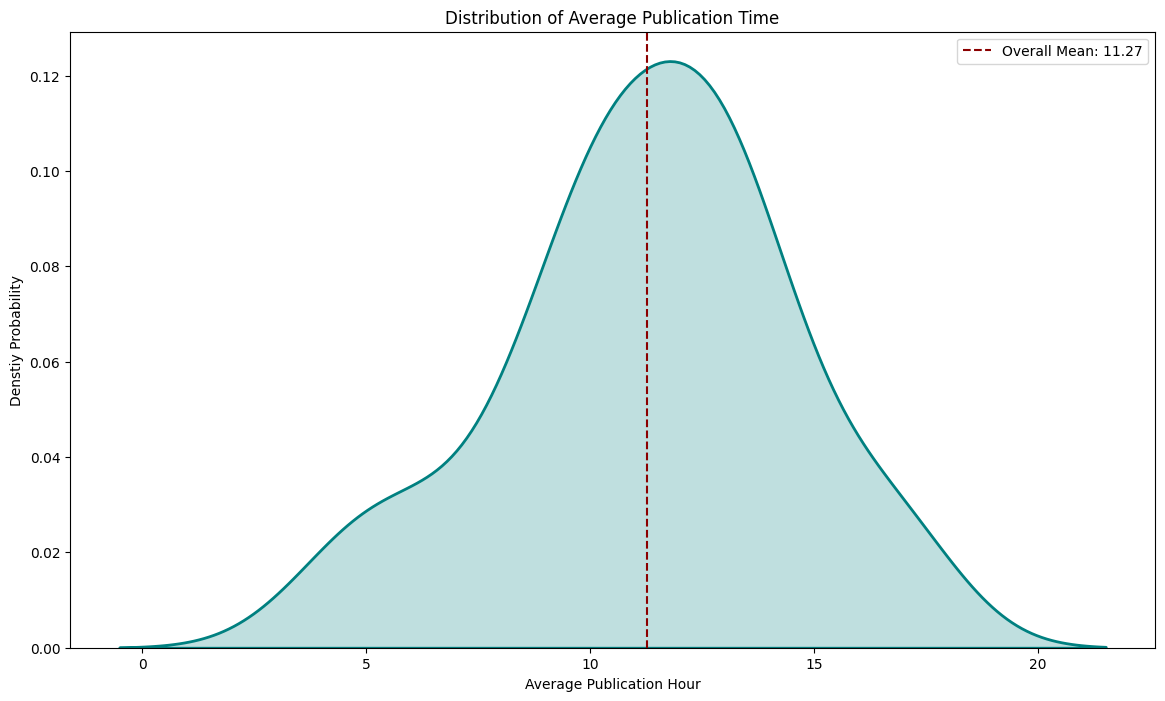

In [10]:
author_aggregated = publication_time.groupby("public_author")["hour"].mean().round(2)
min_hour, max_hour = author_aggregated.min(), author_aggregated.max()
overall_mean = author_aggregated.mean()
plt.figure(figsize=(14, 8))
sns.kdeplot(
    data=author_aggregated,
    color="teal",
    fill=True,
    linewidth=2
)
plt.axvline(overall_mean, color="darkred", linestyle="--", label=f"Overall Mean: {overall_mean:.2f}")
plt.title("Distribution of Average Publication Time")    
plt.xlabel("Average Publication Hour")
plt.ylabel("Denstiy Probability") 
plt.legend()
print(f"Earliest publication: {min_hour} h\nLatest publication: {max_hour} h")

([<matplotlib.axis.XTick at 0x242e9e3cbc0>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

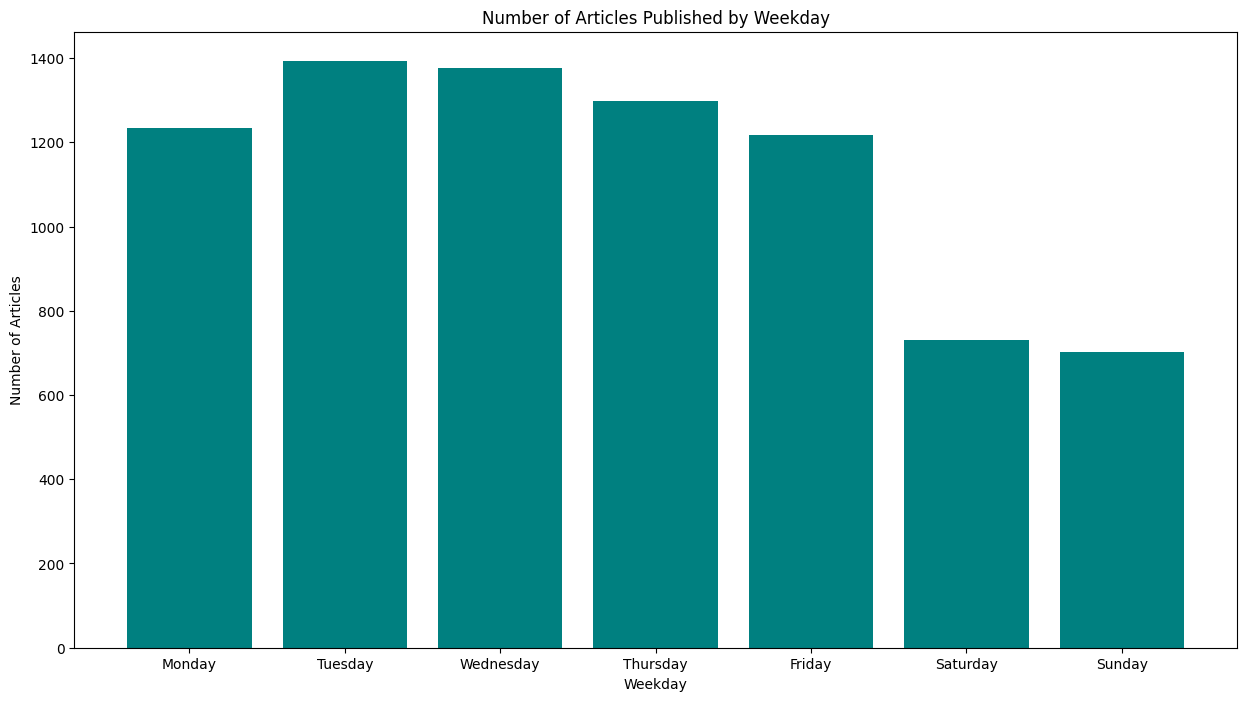

In [104]:
weekday_counts = publication_time.groupby("weekday_num").size()

plt.figure(figsize=(15, 8))
plt.bar(weekday_counts.index, weekday_counts.values, color="teal")
plt.title("Number of Articles Published by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Articles")
plt.xticks(weekday_counts.index, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

([<matplotlib.axis.XTick at 0x242fd4c8140>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

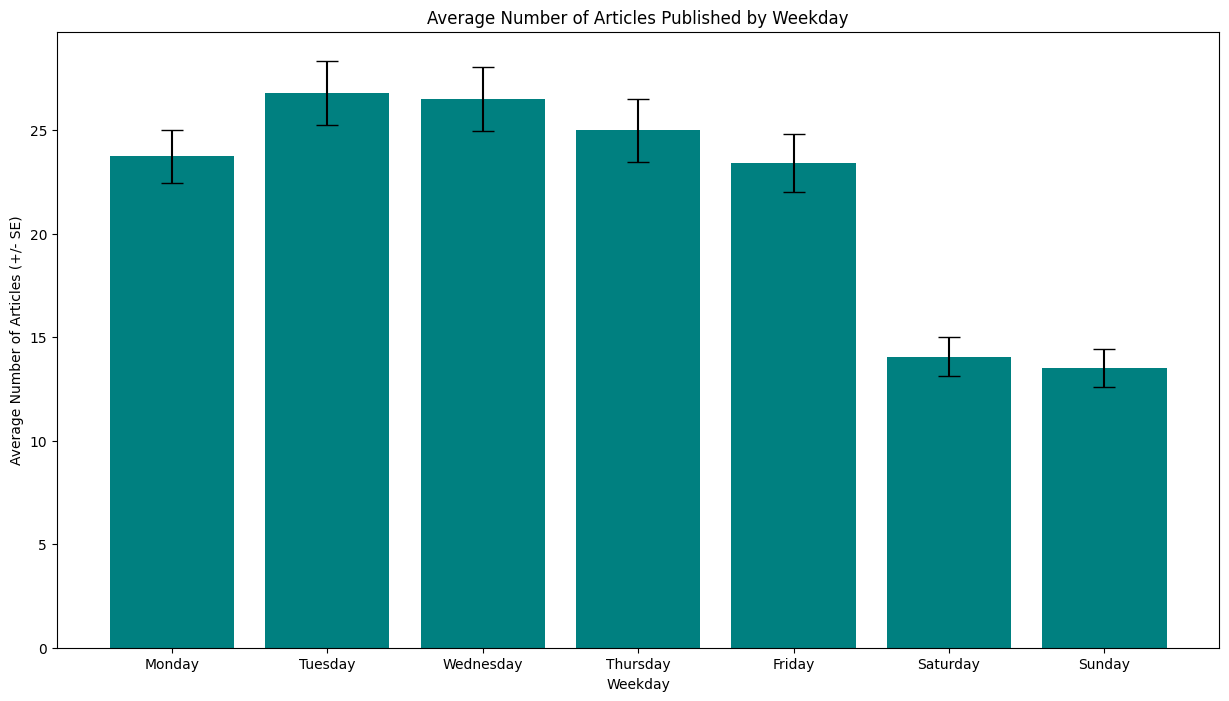

In [178]:
weekly_counts = publication_time.groupby(["week", "weekday_num"]).size().reset_index(name="article_count")
avg_weekly_count = weekly_counts.groupby("weekday_num")["article_count"].mean()
se_avg_weekly_count = weekly_counts.groupby("weekday_num")["article_count"].sem()

plt.figure(figsize=(15, 8))
plt.bar(
    avg_weekly_count.index, 
    avg_weekly_count.values, 
    color="teal", 
    yerr=se_avg_weekly_count,
    capsize=8)
plt.title("Average Number of Articles Published by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Average Number of Articles (+/- SE)")
plt.xticks(avg_weekly_count.index, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])